# CNN for Multi-omics Analysis

In [50]:
# Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
import sys

In [51]:
# Setup Logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler(sys.stdout)])
logger = logging.getLogger(__name__)

## 1. Load and Prepare Data (Simulated)

In [52]:
logger.info("Simulating Data")
num_samples = 50
num_genes_total = 1000
num_proteins_total = 800
num_matched_features = 500 # Number of features common to both omics

np.random.seed(42)
# torch.manual_seed(42)

2025-06-04 23:44:14,617 - INFO - Simulating Data


In [53]:
sample_names = [f'Sample_{i+1}' for i in range(num_samples)]
all_genes = [f'Gene_{i+1}' for i in range(num_genes_total)]
all_proteins = [f'Prot_{i+1}' for i in range(num_proteins_total)]
matched_ids = [f'Gene_{i+1}' for i in range(num_matched_features)]
transcript_ids = matched_ids.copy()  + [ f'Gene_{i+1}' for i in range(num_matched_features, num_genes_total)] # full transcriptome list
protein_col_ids = matched_ids.copy() + [ f'Prot_{i+1}' for i in range(num_matched_features, num_proteins_total)] # full proteome list

Simulate Transcriptomic Data (Samples x Genes)

In [54]:
# values are random numbes, representing expression levels
t_data = np.random.rand(num_samples, len(transcript_ids)) * 10
transcriptomics_df = pd.DataFrame(t_data, index=sample_names, columns=transcript_ids)

Simulate Proteomics Data (Sample x Proteins)

In [55]:
p_data = np.random.rand(num_samples, len(protein_col_ids)) * 5
proteomics_df = pd.DataFrame(p_data, index=sample_names, columns=protein_col_ids)

Simulate outcome labels (Disease vs Control)

In [56]:
# Binary labels (0 or 1) for each sample
labels_np = np.random.randint(0, 2, size=num_samples)
labels_df = pd.DataFrame(labels_np, index=sample_names, columns=['Label'])

In [57]:
logger.info(f"Simulated {num_samples} samples.")
logger.info(f"Raw Transcriptomics shape: {transcriptomics_df.shape} (Samples x Total Genes)")
logger.info(f"Raw Proteomics shape: {proteomics_df.shape} (Samples x Total Proteins)")
logger.info(f"Number of features intended to be matched: {len(matched_ids)}")

2025-06-04 23:44:14,663 - INFO - Simulated 50 samples.
2025-06-04 23:44:14,665 - INFO - Raw Transcriptomics shape: (50, 1000) (Samples x Total Genes)
2025-06-04 23:44:14,667 - INFO - Raw Proteomics shape: (50, 800) (Samples x Total Proteins)
2025-06-04 23:44:14,668 - INFO - Number of features intended to be matched: 500


## 2. Match Features

In [58]:
# Filter the transcriptomics and proteomics dataframes to only include the matched features.
# The column names for these matched features are identical in `matched_ids`.
transcriptomics_matched = transcriptomics_df[matched_ids]
# For proteomics, we also select columns based on `matched_ids` because we simulated
# protein IDs to be the same as gene IDs for the matched portion.
proteomics_matched = proteomics_df[matched_ids]

In [59]:
logger.info(f"Matched transcriptomics shape: {transcriptomics_matched.shape} (Samples x Matched Genes)")
logger.info(f"Matched proteomics shape: {proteomics_matched.shape} (Samples x Matched Proteins)")

2025-06-04 23:44:14,689 - INFO - Matched transcriptomics shape: (50, 500) (Samples x Matched Genes)
2025-06-04 23:44:14,690 - INFO - Matched proteomics shape: (50, 500) (Samples x Matched Proteins)


## 3. Get Pathway Data (Simulated)

In [60]:
# Pathways are sets of genes that work together. We simulate this by grouping our matched gene IDs.
pathways = {} # Dictionary to store pathway_name: [gene_list]. in reality, this would be a list of genes that are known to work together in a biological pathway from gseapy.
genes_per_pathway = 25 # Arbitrary number of genes per simulated pathway
# Calculate how many pathways we need to cover all matched genes
num_pathways_sim = math.ceil(len(matched_ids) / genes_per_pathway)
current_gene_idx_for_pathway = 0 # Keep track of genes assigned to pathways
for i in range(num_pathways_sim):
    pathway_name = f'Pathway_{i+1}'
    # Get a slice of matched_ids for the current pathway
    pathway_genes = matched_ids[current_gene_idx_for_pathway : current_gene_idx_for_pathway + genes_per_pathway]
    if pathway_genes: # Ensure the list is not empty
        pathways[pathway_name] = pathway_genes
    current_gene_idx_for_pathway += genes_per_pathway
logger.info(f"Simulated {len(pathways)} pathways covering the matched genes.")

2025-06-04 23:44:14,701 - INFO - Simulated 20 pathways covering the matched genes.


## 4. Create Pathway Tiling Master Map

In [61]:
# This map defines where each gene/protein pair will be placed on a 2D grid.
# The grid dimensions are chosen to be roughly square and large enough to hold all matched features.
grid_h = int(math.ceil(math.sqrt(len(matched_ids)))) # Height of the grid
grid_w = grid_h # Width of the grid (making it square)
grid_total_pixels = grid_h * grid_w
logger.info(f"Target grid dimensions: {grid_h} (H) x {grid_w} (W) = {grid_total_pixels} pixels")

2025-06-04 23:44:14,711 - INFO - Target grid dimensions: 23 (H) x 23 (W) = 529 pixels


In [62]:
# Create mapping of matched features to grid positions: gene_id: (row, col)
gene_to_position = {}
current_row, current_col = 0, 0

# Sort pathways for consisten ordering (e.g. alhpabetical)
sorted_pathway_names = sorted(pathways.keys())

genes_placed = set()  # Track which genes have been placed

for pathway_name in sorted_pathway_names:
    pathway_genes = pathways[pathway_name]
    sorted_genes_in_pathway = sorted(pathway_genes)  # Sort genes in the pathway for consistent placement
    logger.info(f"Placing genes for {pathway_name}: {sorted_genes_in_pathway}")
    for gene_id in sorted_genes_in_pathway:
        if gene_id in matched_ids and gene_id not in genes_placed: # ensure we only place matched genes and avoid duplicates
            # Place the gene in the current grid position
            gene_to_position[gene_id] = (current_row, current_col) # store the position
            genes_placed.add(gene_id) # mark this gene as placed


            # move to next pixel in the grid
            if current_col >= grid_w:
                current_col = 0
                current_row += 1
        else:
            logger.warning(f"Warning: Grid full ({grid_h}x{grid_w}), cannot place gene {gene_id}.")
            break # Stop if grid is full
    if current_row >= grid_h:  # Stop if grid is full
        logger.warning("Grid is full, stopping placement of genes.")
        break

2025-06-04 23:44:14,722 - INFO - Placing genes for Pathway_1: ['Gene_1', 'Gene_10', 'Gene_11', 'Gene_12', 'Gene_13', 'Gene_14', 'Gene_15', 'Gene_16', 'Gene_17', 'Gene_18', 'Gene_19', 'Gene_2', 'Gene_20', 'Gene_21', 'Gene_22', 'Gene_23', 'Gene_24', 'Gene_25', 'Gene_3', 'Gene_4', 'Gene_5', 'Gene_6', 'Gene_7', 'Gene_8', 'Gene_9']
2025-06-04 23:44:14,724 - INFO - Placing genes for Pathway_10: ['Gene_226', 'Gene_227', 'Gene_228', 'Gene_229', 'Gene_230', 'Gene_231', 'Gene_232', 'Gene_233', 'Gene_234', 'Gene_235', 'Gene_236', 'Gene_237', 'Gene_238', 'Gene_239', 'Gene_240', 'Gene_241', 'Gene_242', 'Gene_243', 'Gene_244', 'Gene_245', 'Gene_246', 'Gene_247', 'Gene_248', 'Gene_249', 'Gene_250']
2025-06-04 23:44:14,724 - INFO - Placing genes for Pathway_11: ['Gene_251', 'Gene_252', 'Gene_253', 'Gene_254', 'Gene_255', 'Gene_256', 'Gene_257', 'Gene_258', 'Gene_259', 'Gene_260', 'Gene_261', 'Gene_262', 'Gene_263', 'Gene_264', 'Gene_265', 'Gene_266', 'Gene_267', 'Gene_268', 'Gene_269', 'Gene_270', 'Ge

## 5. Generate 2-Channel Images for Each Sample

In [63]:
logging.info("Generating 2D grid positions for matched features.")
# list to hold all sample iamges
all_sample_images = []

# Define fill value for missing gnes or empty pixels
fill_value = 0.0

for sample_name in sample_names:
    # Create emptty channels for this sample
    channel_T = np.full((grid_h, grid_w), fill_value, dtype=np.float32)
    channel_P = np.full((grid_h, grid_w), fill_value, dtype=np.float32)

    # Get the data row for the current sample
    t_sample_data = transcriptomics_matched.loc[sample_name]
    p_sample_data = proteomics_matched.loc[sample_name]

    # Populate channels using the master map
    for gene_id, (r,c) in gene_to_position.items():
        # Check if gene/protein exists in the sample's data
        if gene_id in t_sample_data.index:
            channel_T[r, c] = t_sample_data[gene_id]
        if gene_id in p_sample_data.index: # Remember protein columns use gene_id
            channel_P[r, c] = p_sample_data[gene_id]

    sample_image = np.stack((channel_T, channel_P), axis=-1)  # Stack channels
    all_sample_images.append(sample_image)

2025-06-04 23:44:14,753 - INFO - Generating 2D grid positions for matched features.


In [64]:
# Convert the list of images into a single NumPy array (N x H x W x 2)
# This is the input for the CNN
cnn_input_data = np.array(all_sample_images)

logging.info(f"Generated CNN input data with shape: {cnn_input_data.shape}") # (num_samples, H, W, 2)


2025-06-04 23:44:14,953 - INFO - Generated CNN input data with shape: (50, 23, 23, 2)


## 6.  Visualize an Example Image

2025-06-04 23:44:14,964 - INFO - 
--- Visualizing Example Image (Sample 0) ---


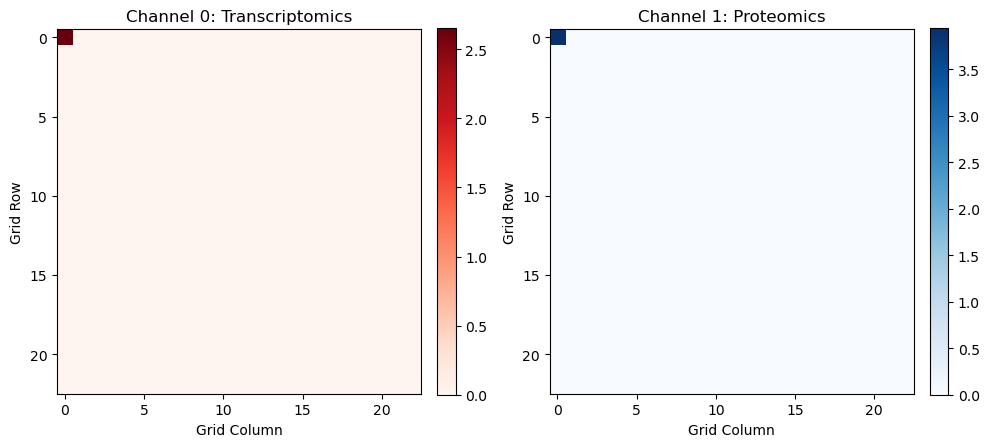

In [65]:
logging.info("\n--- Visualizing Example Image (Sample 0) ---")
example_image = cnn_input_data[0] # Get the first sample's image

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Transcriptomics Channel (Channel 0)
im0 = axes[0].imshow(example_image[:, :, 0], cmap='Reds', interpolation='nearest')
axes[0].set_title('Channel 0: Transcriptomics')
axes[0].set_xlabel('Grid Column')
axes[0].set_ylabel('Grid Row')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot Proteomics Channel (Channel 1)
im1 = axes[1].imshow(example_image[:, :, 1], cmap='Blues', interpolation='nearest')
axes[1].set_title('Channel 1: Proteomics')
axes[1].set_xlabel('Grid Column')
axes[1].set_ylabel('Grid Row')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
print(num_pathways_sim)

20


: 